# 4a - Neural Machine Translation by Jointly Learning to Align and Translate

# Import Libraries



In [ ]:
#!pip install -U spacy

In [ ]:
#!pip install -U swifter

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext 
from torchtext.datasets import Multi30k
from torchtext.vocab import vocab
import torch.nn.functional as F
from torchtext.legacy.data import  BucketIterator

import spacy
import numpy as np
from collections import Counter

import random
import math
import time
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#import swifter

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
data_folder = Path('/home/harpreet/Insync/google_drive_shaannoor/Data/NLP')
project_folder = Path('/home/harpreet/Insync/google_drive_harpreet/Research/NLP/pytorch-seq2seq')

In [ ]:
torchtext.__version__, torch.__version__, torch.cuda.is_available(), spacy.__version__

('0.11.0', '1.10.0', True, '3.2.4')

# Set Seeds

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Load Tokenized Data

Next, we download and load the train, validation and test data. 

The dataset we'll be using is the [Multi30k dataset](https://github.com/multi30k/dataset). This is a dataset with ~30,000 parallel English, German and French sentences, each with ~12 words per sentence. 

The data was tokenized in Tutorial 1 and we will load the tokenized data

In [ ]:
df_train = pd.read_pickle(project_folder/'df_train_en_de.pickel')
df_test =  pd.read_pickle(project_folder/'df_test_en_de.pickel')
df_valid = pd.read_pickle(project_folder/'df_valid_en_de.pickel')

In [ ]:
df_train

,source_tokens,target_tokens,source_tokens_reverse
0,"[zwei, junge, weiße, männer, sind, i, m, freie...","[two, young, ,, white, males, are, outside, ne...","[., büsche, vieler, nähe, der, in, freien, m, ..."
1,"[mehrere, männer, mit, schutzhelmen, bedienen,...","[several, men, in, hard, hats, are, operating,...","[., antriebsradsystem, ein, bedienen, schutzhe..."
2,"[ein, kleines, mädchen, klettert, in, ein, spi...","[a, little, girl, climbing, into, a, wooden, p...","[., holz, aus, spielhaus, ein, in, klettert, m..."
3,"[ein, mann, in, einem, blauen, hemd, steht, au...","[a, man, in, a, blue, shirt, is, standing, on,...","[., fenster, ein, putzt, und, leiter, einer, a..."
4,"[zwei, männer, stehen, am, herd, und, bereiten...","[two, men, are, at, the, stove, preparing, foo...","[., zu, essen, bereiten, und, herd, am, stehen..."
...,...,...,...
28995,"[., wand, verschnörkelten, einer, hinter, schr...","[a, woman, behind, a, scrolled, wall, is, writ...","[eine, frau, schreibt, hinter, einer, verschnö..."
28996,"[., kletterwand, einer, an, übt, bergsteiger, ...","[a, rock, climber, practices, on, a, rock, cli...","[ein, bergsteiger, übt, an, einer, kletterwand..."
28997,"[., hauses, einem, vor, straße, einer, auf, ar...","[two, male, construction, workers, are, workin...","[zwei, bauarbeiter, arbeiten, auf, einer, stra..."
28998,"[., fassade, einer, vor, wagen, einem, mit, ju...","[an, elderly, man, sits, outside, a, storefron...","[ein, älterer, mann, sitzt, mit, einem, jungen..."


In [ ]:
df_valid

,source_tokens,target_tokens,source_tokens_reverse
0,"[eine, gruppe, von, männern, lädt, baumwolle, ...","[a, group, of, men, are, loading, cotton, onto...","[lastwagen, einen, auf, baumwolle, lädt, männe..."
1,"[ein, mann, schläft, in, einem, grünen, raum, ...","[a, man, sleeping, in, a, green, room, on, a, ...","[., sofa, einem, auf, raum, grünen, einem, in,..."
2,"[ein, junge, mit, kopfhörern, sitzt, auf, den,...","[a, boy, wearing, headphones, sits, on, a, wom...","[., frau, einer, schultern, den, auf, sitzt, k..."
3,"[zwei, männer, bauen, eine, blaue, eisfischerh...","[two, men, setting, up, a, blue, ice, fishing,...","[auf, see, zugefrorenen, einem, auf, eisfische..."
4,"[ein, mann, mit, beginnender, glatze, ,, der, ...","[a, balding, man, wearing, a, red, life, jacke...","[., boot, kleinen, einem, in, sitzt, ,, trägt,..."
...,...,...,...
1009,"[., her, zuckerwatte, mann, ein, stellt, jahrm...","[at, some, sort, of, carnival, ,, a, man, is, ...","[bei, einer, art, jahrmarkt, stellt, ein, mann..."
1010,"[., bus, einem, vor, steht, polizisten, von, g...","[a, bunch, of, police, officers, are, standing...","[eine, gruppe, von, polizisten, steht, vor, ei..."
1011,"[., hindurch, brillengläser, ihre, durch, blic...","[a, elderly, white, -, haired, woman, is, look...","[eine, ältere, weißhaarige, frau, sieht, in, i..."
1012,"[., freien, m, i, telefonzellen, an, stehen, m...","[two, men, are, standing, at, telephone, booth...","[zwei, männer, stehen, an, telefonzellen, i, m..."


In [ ]:
df_test

,source_tokens,target_tokens,source_tokens_reverse
0,"[ein, mann, mit, einem, orangefarbenen, hut, ,...","[a, man, in, an, orange, hat, starring, at, so...","[., anstarrt, etwas, der, ,, hut, orangefarben..."
1,"[ein, boston, terrier, läuft, über, saftig, -,...","[a, boston, terrier, is, running, on, lush, gr...","[., zaun, weißen, einem, vor, gras, grünes, -,..."
2,"[ein, mädchen, in, einem, karateanzug, bricht,...","[a, girl, in, karate, uniform, breaking, a, st...","[., tritt, einem, mit, stock, einen, bricht, k..."
3,"[fünf, leute, in, winterjacken, und, mit, helm...","[five, people, wearing, winter, jackets, and, ...","[., hintergrund, m, i, schneemobilen, mit, sch..."
4,"[leute, reparieren, das, dach, eines, hauses, .]","[people, are, fixing, the, roof, of, a, house, .]","[., hauses, eines, dach, das, reparieren, leute]"
...,...,...,...
995,"[., stehen, herum, sie, um, personen, andere, ...","[marathon, runners, are, racing, on, a, city, ...","[marathonläufer, laufen, auf, einer, städtisch..."
996,"[., fahrradfahren, beim, sonnenhut, einen, trä...","[asian, woman, wearing, a, sunhat, while, ridi...","[asiatische, frau, trägt, einen, sonnenhut, be..."
997,"[., bäumen, zwei, bei, boden, dem, auf, spiele...","[some, children, are, outside, playing, in, th...","[ein, paar, kinder, sind, i, m, freien, und, s..."
998,"[., videospiel, ein, spielt, mann, älterer, ein]","[an, older, man, is, playing, a, video, arcade...","[ein, älterer, mann, spielt, ein, videospiel, .]"


# Build Vocab

In [ ]:
def create_vocab(text, min_freq, specials):
    my_counter = Counter()
    for line in text:
       my_counter.update(line)
    my_vocab = vocab(my_counter, min_freq=min_freq)
    for i, special in enumerate(specials):
        my_vocab.insert_token(special, i)
    my_vocab.set_default_index(0)
    return my_vocab

In [ ]:
source_vocab = create_vocab(df_train['source_tokens'], 2, ['<unk>', '<BOS>', '<EOS>', '<PAD>'])

In [ ]:
len(source_vocab)

7874

In [ ]:
pd.DataFrame(source_vocab.get_stoi().items(), columns=['tokens', 'index']).sort_values(by = ['index'])

,tokens,index
4986,<unk>,0
3333,<BOS>,1
3840,<EOS>,2
4539,<PAD>,3
3551,zwei,4
...,...,...
2,geländefahrzeugs,7869
1,sonnentag,7870
0,lederoberteil,7871
2376,reisfeld,7872


In [ ]:
# check index of unknown word - it should be zero
source_vocab['abracdabra']

0

In [ ]:
target_vocab = create_vocab(df_train['target_tokens'], 2, ['<unk>', '<BOS>', '<EOS>', '<PAD>'])

In [ ]:
len(target_vocab)

5893

# Create Dataset and Dataloader

## Custom Class Dataset

In [ ]:
class EngGerman(Dataset):
    def __init__(self, X1, X2):
        self.X1 = X1
        self.X2 = X2
        
    def __len__(self):
        return len(self.X1)
    
    def __getitem__(self, indices):
        return (self.X1.iloc[indices] , self.X2.iloc[indices]) 

In [ ]:
trainset = EngGerman(df_train['source_tokens'], df_train['target_tokens'])
testset = EngGerman(df_test['source_tokens'], df_test['target_tokens'])
validset = EngGerman(df_valid['source_tokens'], df_valid['target_tokens'])

In [ ]:
trainset.__getitem__(0)

(['zwei',
  'junge',
  'weiße',
  'männer',
  'sind',
  'i',
  'm',
  'freien',
  'in',
  'der',
  'nähe',
  'vieler',
  'büsche',
  '.'],
 ['two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.'])

In [ ]:
len(trainset), len(testset), len(validset)

(29000, 1000, 1014)

## Create Dataloader

### Collate Function

In [ ]:
def text_transform (my_vocab, text):
     text_numerical = [my_vocab[token] for token in text]
     return torch.tensor([my_vocab['<BOS>']] + text_numerical + [my_vocab['<EOS>']])
     #return list(my_vocab['<BOS>']) + text_numerical + list(my_vocab['<EOS>'])

In [ ]:
text = trainset.__getitem__(12)[1]
print(text)
text_transform(target_vocab, text)

['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']


tensor([ 1, 21, 90, 91, 92, 21, 93, 91,  9, 94,  2])

In [ ]:
def collate_batch(batch):
   source_list, target_list, source_lengths, target_lengths = [], [], [], []
   for (source_text, target_text) in batch:
        source_transform = text_transform(source_vocab, source_text)
        source_list.append(source_transform)
        source_lengths.append(source_transform.size(0))
        
        target_transform =text_transform(target_vocab, target_text)
        target_list.append(target_transform)
        target_lengths.append(target_transform.size(0))
        
   source_pad = pad_sequence(source_list, padding_value=3.0)
   target_pad = pad_sequence(target_list, padding_value=3.0)
   source_lengths = torch.tensor(source_lengths, dtype=torch.int64)
   target_lengths = torch.tensor(target_lengths, dtype=torch.int64)
   #print(source_list)
   return (source_pad, source_lengths, target_pad, target_lengths)

### Batch Sampler

In [ ]:
subset_train = torch.utils.data.Subset(trainset, range(15))

In [ ]:
indices = [(i, len(x)) for i, (x, x) in enumerate(subset_train)]

In [ ]:
indices

[(0, 11),
 (1, 12),
 (2, 9),
 (3, 15),
 (4, 9),
 (5, 15),
 (6, 8),
 (7, 14),
 (8, 12),
 (9, 11),
 (10, 10),
 (11, 16),
 (12, 9),
 (13, 16),
 (14, 8)]

In [ ]:
random.seed(0)
random.shuffle(indices)

In [ ]:
indices

[(1, 12),
 (10, 10),
 (9, 11),
 (5, 15),
 (11, 16),
 (2, 9),
 (3, 15),
 (7, 14),
 (8, 12),
 (4, 9),
 (0, 11),
 (14, 8),
 (12, 9),
 (6, 8),
 (13, 16)]

In [ ]:
batch_size = 2
pooled_indices = []
pool_num = 1
for i in range(0, len(indices), batch_size * 5):
    print(f'pool number:{pool_num}')
    current_pool = sorted(indices[i:i + batch_size * 5], 
                                 key=lambda x: x[1])
    print(current_pool)
    pooled_indices.extend(current_pool)
    pool_num += 1 

pool number:1
[(2, 9), (4, 9), (10, 10), (9, 11), (1, 12), (8, 12), (7, 14), (5, 15), (3, 15), (11, 16)]
pool number:2
[(14, 8), (6, 8), (12, 9), (0, 11), (13, 16)]


In [ ]:
pooled_indices

[(2, 9),
 (4, 9),
 (10, 10),
 (9, 11),
 (1, 12),
 (8, 12),
 (7, 14),
 (5, 15),
 (3, 15),
 (11, 16),
 (14, 8),
 (6, 8),
 (12, 9),
 (0, 11),
 (13, 16)]

In [ ]:
pooled_indices = [x[0] for x in pooled_indices]

In [ ]:
pooled_indices

[2, 4, 10, 9, 1, 8, 7, 5, 3, 11, 14, 6, 12, 0, 13]

In [ ]:
batches = []
for i in range(0, len(pooled_indices), batch_size):
    batches.append(pooled_indices[i:i + batch_size])    

In [ ]:
batches

[[2, 4], [10, 9], [1, 8], [7, 5], [3, 11], [14, 6], [12, 0], [13]]

In [ ]:
random.shuffle(batches)

In [ ]:
batches

[[14, 6], [3, 11], [7, 5], [12, 0], [2, 4], [10, 9], [13], [1, 8]]

In [ ]:
from torch.utils.data.sampler import Sampler
class MinPadBatchSampler(Sampler):
    
    def __init__(self, dataset, batch_size, pool_size):
        
        self.batch_size = batch_size
        self.dataset = dataset
        self.pool_size = pool_size
       
    def __iter__(self):
        indices = [(i, len(x)) for i, (x, y) in enumerate(self.dataset)]
        random.shuffle(indices)
        pooled_indices = []
        # create pool of indices with similar lengths 
        for i in range(0, len(indices), self.batch_size * self.pool_size):
            pooled_indices.extend(sorted(indices[i:i + self.batch_size * self.pool_size], 
                                         key=lambda x: x[1]))

        pooled_indices = [x[0] for x in pooled_indices]
        
        batches = []
        for i in range(0, len(pooled_indices), self.batch_size):
            batches.append(pooled_indices[i:i + self.batch_size])
        random.shuffle(batches)
        
        self.num_batches = len(batches)
        
        return iter(batches)

    
    def __len__(self):
        return self.num_batches

In [ ]:
test_batch_sampler = MinPadBatchSampler(subset_train, 2, 5)
for i in test_batch_sampler:
    print(i)
    
print(len(test_batch_sampler))

[12, 14]
[0, 7]
[1, 10]
[6, 9]
[2, 8]
[3, 5]
[4, 13]
[11]
8


In [ ]:
BATCH_SIZE = 128

min_pad_batch_sampler = MinPadBatchSampler(trainset, BATCH_SIZE, 50)
train_loader = DataLoader(trainset, 
                          batch_sampler=min_pad_batch_sampler, 
                          collate_fn=collate_batch)

valid_loader = DataLoader(validset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False, 
                          collate_fn=collate_batch)
test_loader = DataLoader(testset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True,
                         collate_fn=collate_batch)

In [ ]:
for src, src_len, trg, trg_len in train_loader:
    print('source\n', src)
    print('source_lengths\n', src_len)
    break

source
 tensor([[   1,    1,    1,  ...,    1,    1,    1],
        [  17,   17,   17,  ...,   17,   17,   17],
        [ 184,    0, 1103,  ..., 2625,  455, 3289],
        ...,
        [  29,   29,  878,  ...,   68,  125,  125],
        [  22,   22,    4,  ...,   66,   48,   48],
        [   2,    2,    2,  ...,    2,    2,    2]])
source_lengths
 tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14])


## Building the Seq2Seq Model

### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*. With a bidirectional RNN, we have two RNNs in each layer. A *forward RNN* going over the embedded sentence from left to right (shown below in green), and a *backward RNN* going over the embedded sentence from right to left (teal). All we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before. 

![](assets/seq2seq8.png)

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

As before, we only pass an input (`embedded`) to the RNN, which tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros. We'll also get two context vectors, one from the forward RNN after it has seen the final word in the sentence, $z^\rightarrow=h_T^\rightarrow$, and one from the backward RNN after it has seen the first word in the sentence, $z^\leftarrow=h_T^\leftarrow$.

The RNN returns `outputs` and `hidden`. 

`outputs` is of size **[src len, batch size, hid dim * num directions]** where the first `hid_dim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hid_dim` elements are hidden states from the top layer backward RNN. We can think of the third axis as being the forward and backward hidden states concatenated together other, i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ and we can denote all encoder hidden states (forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

`hidden` is of size **[n layers * num directions, batch size, hid dim]**, where **[-2, :, :]** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence) and **[-1, :, :]** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).

As the decoder is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$, and we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function. 

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**Note**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so we have changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.

The changes here all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. Note that the tensor containing the lengths of the sequences must be a CPU tensor as of the latest version of PyTorch, which we explicitly do so with `to('cpu')`. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final **non-padded element** in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
                
        #need to explicitly put lengths on cpu!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'),
                                                            enforce_sorted=False)
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden


### Attention

Next up is the attention layer. This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src len]** tensor for each example in the batch. We want this to be **[src len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of $v$ as the weights for a weighted sum of the energy across all encoder hidden states. These weights tell us how much we should attend to each token in the source sequence. The parameters of $v$ are initialized randomly, but learned with the rest of the model via backpropagation. Note how $v$ is not dependent on time, and the same $v$ is used for each time-step of the decoding. We implement $v$ as a linear layer without a bias.

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/teal blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

![](assets/seq2seq9.png)

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using *masking*, we can force the attention to only be over non-padding elements.

The `forward` method now takes a `mask` input. This is a **[batch size, source sentence length]** tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: ["hello", "how", "are", "you", "?", `<pad>`, `<pad>`], then the mask would be [1, 1, 1, 1, 1, 0, 0].

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The embedded input word, $d(y_t)$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $d(y_t)$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

We then pass $d(y_t)$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](assets/seq2seq10.png)

The green/teal blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the `attentions` 

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs
 

# Training the Seq2Seq Model

The rest of this tutorial is very similar to the previous one. 

We initialise our encoder, decoder and seq2seq model (placing it on the GPU if we have one). As before, the embedding dimensions and the amount of dropout used can be different between the encoder and the decoder, but the hidden dimensions must remain the same.

In [ ]:
source_vocab['<PAD>']

3

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_DIM = len(source_vocab)
OUTPUT_DIM = len(target_vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = source_vocab['<PAD>']

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

Next, we initialize our parameters. The paper states the parameters are initialized from a normal distribution with a mean of 0 and a standard deviation of 0.01, i.e. $\mathcal{N}(0, 0.01)$. 

It also states we should initialize the recurrent parameters to a special initialization, however to keep things simple we'll also initialize them to $\mathcal{N}(0, 0.01)$.

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7874, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

We also define a function that will calculate the number of trainable parameters in the model.

Even though we only have a single layer RNN for our encoder and decoder we actually have **more** parameters  than the last model. This is due to the increased size of the inputs to the GRU and the linear layer. However, it is not a significant amount of parameters and causes a minimal amount of increase in training time (~3 seconds per epoch extra).

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,523,781 trainable parameters


We define our optimizer, which we use to update our parameters in the training loop. Check out [this](http://ruder.io/optimizing-gradient-descent/) post for information about different optimizers. Here, we'll use Adam.

In [ ]:
optimizer = optim.Adam(model.parameters())

Next, we define our loss function. The `CrossEntropyLoss` function calculates both the log softmax as well as the negative log-likelihood of our predictions. 

Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [ ]:
TRG_PAD_IDX = target_vocab['<PAD>']
TRG_PAD_IDX

3

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Next, we'll define our training loop. 

First, we'll set the model into "training mode" with `model.train()`. This will turn on dropout (and batch normalization, which we aren't using) and then iterate through our data iterator.

As stated before, our decoder loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

Here, when we calculate the loss, we cut off the first element of each tensor to get:

$$\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

At each iteration:
- get the source and target sentences from the batch, $X$ and $Y$
- zero the gradients calculated from the last batch
- feed the source and target into the model to get the output, $\hat{Y}$
- as the loss function only works on 2d inputs with 1d targets we need to flatten each of them with `.view`
    - we slice off the first column of the output and target tensors as mentioned above
- calculate the gradients with `loss.backward()`
- clip the gradients to prevent them from exploding (a common issue in RNNs)
- update the parameters of our model by doing an optimizer step
- sum the loss value to a running total

Finally, we return the loss that is averaged over all batches.

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
        
   
    for src, src_len, trg, trg_len in iterator:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        #print('test')
        
        epoch_loss += loss.item()
        #n += 1
        #print(n)
        
    return epoch_loss /len(iterator)

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

We must remember to set the model to evaluation mode with `model.eval()`. This will turn off dropout (and batch normalization, if used).

We use the `with torch.no_grad()` block to ensure no gradients are calculated within the block. This reduces memory consumption and speeds things up. 

The iteration loop is similar (without the parameter updates), however we must ensure we turn teacher forcing off for evaluation. This will cause the model to only use it's own predictions to make further predictions within a sentence, which mirrors how it would be used in deployment.

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg, trg_len in iterator:

            src = src.to(device)
            trg = trg.to(device)

            output = model(src, src_len, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Next, we'll create a function that we'll use to tell us how long an epoch takes.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We can finally start training our model!

At each epoch, we'll be checking if our model has achieved the best validation loss so far. If it has, we'll update our best validation loss and save the parameters of our model (called `state_dict` in PyTorch). Then, when we come to test our model, we'll use the saved parameters used to achieve the best validation loss. 

We'll be printing out both the loss and the perplexity at each epoch. It is easier to see a change in perplexity than a change in loss as the numbers are much bigger.

In [ ]:
N_EPOCHS = 7
CLIP = 1
BATCH_SIZE = 128

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '4a-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 29s
	Train Loss: 5.106 | Train PPL: 164.959
	 Val. Loss: 4.887 |  Val. PPL: 132.595
Epoch: 02 | Time: 0m 30s
	Train Loss: 4.088 | Train PPL:  59.630
	 Val. Loss: 4.150 |  Val. PPL:  63.411
Epoch: 03 | Time: 0m 29s
	Train Loss: 3.325 | Train PPL:  27.813
	 Val. Loss: 3.726 |  Val. PPL:  41.497
Epoch: 04 | Time: 0m 29s
	Train Loss: 2.811 | Train PPL:  16.628
	 Val. Loss: 3.605 |  Val. PPL:  36.787
Epoch: 05 | Time: 0m 29s
	Train Loss: 2.419 | Train PPL:  11.238
	 Val. Loss: 3.341 |  Val. PPL:  28.240
Epoch: 06 | Time: 0m 29s
	Train Loss: 2.126 | Train PPL:   8.379
	 Val. Loss: 3.354 |  Val. PPL:  28.619
Epoch: 07 | Time: 0m 29s
	Train Loss: 1.890 | Train PPL:   6.620
	 Val. Loss: 3.272 |  Val. PPL:  26.366


We'll load the parameters (`state_dict`) that gave our model the best validation loss and run it the model on the test set.

In [ ]:
model.load_state_dict(torch.load('4a-model.pt'))

test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.295 | Test PPL:  26.969 |


In the following notebook we'll implement a model that achieves improved test perplexity, but only uses a single layer in the encoder and the decoder.

## Inference

Now we can use our trained model to generate translations.

**Note:** these translations will be poor compared to examples shown in paper as they use hidden dimension sizes of 1000 and train for 4 days! They have been cherry picked in order to show off what attention should look like on a sufficiently sized model.

Our `translate_sentence` will do the following:
- ensure our model is in evaluation mode, which it should always be for inference
- tokenize the source sentence if it has not been tokenized (is a string)
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- get the length of the source sentence and convert to a tensor
- feed the source sentence into the encoder
- create the mask for the source sentence
- create a list to hold the output sentence, initialized with an `<sos>` token
- create a tensor to hold the attention values
- while we have not hit a maximum length
  - get the input tensor, which should be either `<sos>` or the last predicted token
  - feed the input, all encoder outputs, hidden state and mask into the decoder
  - store attention values
  - get the predicted next token
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention values over the sequence

In [ ]:
[target_vocab['<BOS>']]

[1]

In [ ]:
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm', disable = ['tok2vec', 'tagger', 'morphologizer', 
                                                       'parser', 'attribute_ruler', 'lemmatizer', 'ner'])   
        tokens = [token.text.lower() for token in nlp(sentence) if token.text not in ['\n']]
    else:
        tokens = [token.lower() for token in sentence]
        
    src_indexes = [src_vocab['<BOS>']] + [src_vocab[token] for token in tokens] + [src_vocab['<EOS>']]
    src_tensor  =   torch.LongTensor(src_indexes )
  
    src_tensor = src_tensor.unsqueeze(1).to(device)
    # seq_len, batch_size

    src_len = torch.LongTensor([len(src_indexes)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [trg_vocab['<BOS>']]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_vocab['<EOS>']:
            break
    
    trg_tokens = [target_vocab.get_itos()[i]for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [ ]:
example_idx = 12

src = trainset[example_idx][0]
trg = trainset[example_idx][1]

In [ ]:
src_indexes = [source_vocab['<BOS>']] + [source_vocab[token] for token in tokens] + [source_vocab['<EOS>']]
src_indexes

[1, 22, 93, 94, 37, 22, 95, 94, 96, 17, 2]

In [ ]:
src_tensor  =   torch.LongTensor(src_indexes )
src_tensor

tensor([ 1, 22, 93, 94, 37, 22, 95, 94, 96, 17,  2])

In [ ]:
src_tensor.shape

torch.Size([11])

In [ ]:
src_tensor = src_tensor.unsqueeze(1).to(device)
src_tensor.shape

torch.Size([11, 1])

In [ ]:
src_tensor.shape[0]

11

In [ ]:
src_len = torch.LongTensor([len(src_indexes)])
src_len

tensor([11])

In [ ]:
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7874, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7874, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
with torch.no_grad():
    encoder_outputs, hidden = model.encoder(src_tensor, src_len)

In [ ]:
 mask = model.create_mask(src_tensor)

In [ ]:
mask

tensor([[True, True, True, True, True, True, True, True, True, True, True]],
       device='cuda:0')

In [ ]:
trg_indexes = [target_vocab['<BOS>']]

In [ ]:
max_len = 50
attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)

In [ ]:
trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)

In [ ]:
with torch.no_grad():
    output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

In [ ]:
attention.shape

torch.Size([1, 11])

In [ ]:
attentions[0] = attention

In [ ]:
pred_token = output.argmax(1).item()

In [ ]:
trg_indexes.append(pred_token)

Next, we'll make a function that displays the model's attention over the source sentence for each target token generated.

In [ ]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Now, we'll grab some translations from our dataset and see how well our model did. Note, we're going to cherry pick examples here so it gives us something interesting to look at, but feel free to change the `example_idx` value to look at different examples.

First, we'll get a source and target from our dataset.

In [ ]:
example_idx = 12

src = trainset[example_idx][0]
trg = trainset[example_idx][1]

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'schwarzer', 'hund', 'und', 'ein', 'gefleckter', 'hund', 'kämpfen', '.']
trg = ['a', 'black', 'dog', 'and', 'a', 'spotted', 'dog', 'are', 'fighting']


Then we'll use our `translate_sentence` function to get our predicted translation and attention. We show this graphically by having the source sentence on the x-axis and the predicted translation on the y-axis. The lighter the square at the intersection between two words, the more attention the model gave to that source word when translating that target word.

Below is an example the model attempted to translate, it gets the translation correct except changes *are fighting* to just *fighting*.

In [ ]:
translation, attention = translate_sentence(src, source_vocab, target_vocab, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'black', 'dog', 'and', 'a', 'dog', 'and', 'a', 'dog', 'fighting', 'fighting', '.', '<EOS>']


/tmp/ipykernel_6384/4268658779.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/tmp/ipykernel_6384/4268658779.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


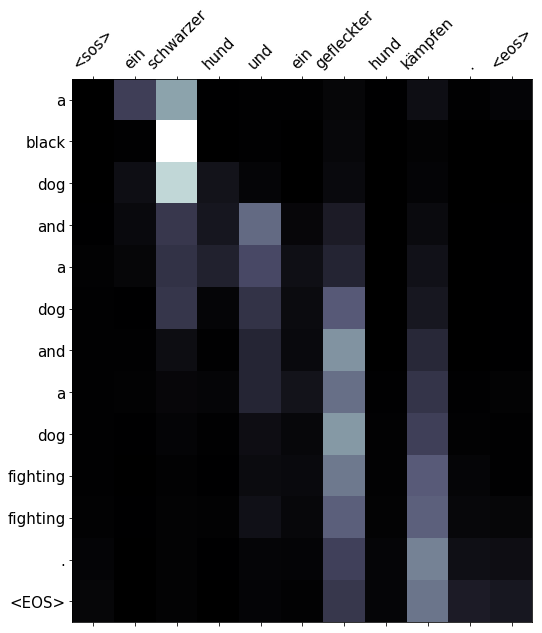

In [ ]:
display_attention(src, translation, attention)

Translations from the training set could simply be memorized by the model. So it's only fair we look at translations from the validation and testing set too.

Starting with the validation set, let's get an example.

In [ ]:
example_idx = 14

src = validset[example_idx][0]
trg = validset[example_idx][1]

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'spielt', 'ein', 'lied', 'auf', 'ihrer', 'geige', '.']
trg = ['a', 'female', 'playing', 'a', 'song', 'on', 'her', 'violin', '.']


Then let's generate our translation and view the attention.

Here, we can see the translation is the same except for swapping *female* with *woman*.

predicted trg = ['a', 'woman', 'playing', 'a', 'song', 'at', 'a', 'song', '.', '<EOS>']


/tmp/ipykernel_6384/4268658779.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/tmp/ipykernel_6384/4268658779.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


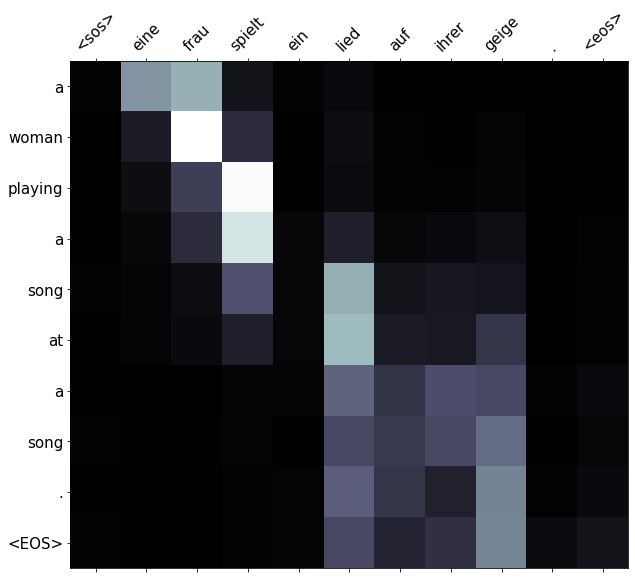

In [ ]:
translation, attention = translate_sentence(src, source_vocab, target_vocab, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

Finally, let's get an example from the test set.

In [ ]:
example_idx = 18

src = validset[example_idx][0]
trg = validset[example_idx][1]

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'junge', 'frau', 'fertigt', 'i', 'm', 'regenwald', 'teppiche', 'an']
trg = ['a', 'young', 'woman', 'is', 'making', 'rugs', 'in', 'the', 'rain', 'forest']


Again, it produces a slightly different translation than target, a more literal version of the source sentence. It swaps *mountain climbing* for *climbing a mountain*.

predicted trg = ['a', 'young', 'woman', 'is', 'a', 'a', '<unk>', 'peppers', '.', '<EOS>']


/tmp/ipykernel_6384/4268658779.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/tmp/ipykernel_6384/4268658779.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


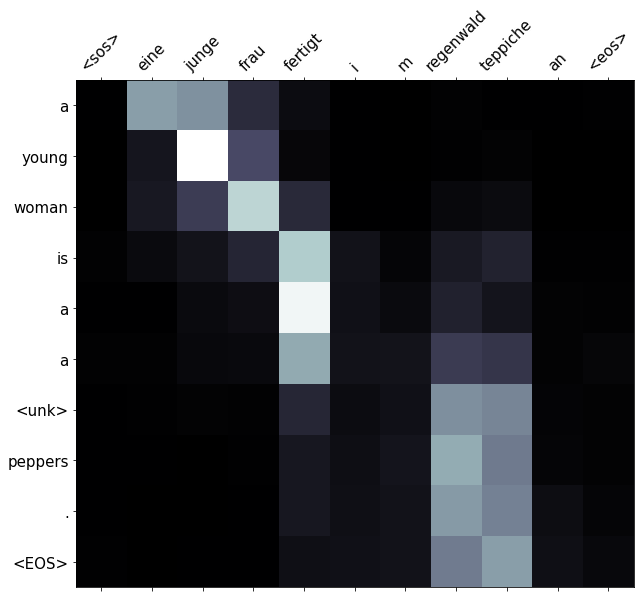

In [ ]:
translation, attention = translate_sentence(src, source_vocab, target_vocab, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

## BLEU

Previously we have only cared about the loss/perplexity of the model. However there metrics that are specifically designed for measuring the quality of a translation - the most popular is *BLEU*. Without going into too much detail, BLEU looks at the overlap in the predicted and actual target sequences in terms of their n-grams. It will give us a number between 0 and 1 for each sequence, where 1 means there is perfect overlap, i.e. a perfect translation, although is usually shown between 0 and 100. BLEU was designed for multiple candidate translations per source sequence, however in this dataset we only have one candidate per source.

We define a `calculate_bleu` function which calculates the BLEU score over a provided TorchText dataset. This function creates a corpus of the actual and predicted translation for each source sentence and then calculates the BLEU score.

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

We get a BLEU of around 28. If we compare it to the paper that the attention model is attempting to replicate, they achieve a BLEU score of 26.75. This is similar to our score, however they are using a completely different dataset and their model size is much larger - 1000 hidden dimensions which takes 4 days to train! - so we cannot really compare against that either.

This number isn't really interpretable, we can't really say much about it. The most useful part of a BLEU score is that it can be used to compare different models on the same dataset, where the one with the **higher** BLEU score is "better".

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 28.11


In the next tutorials we will be moving away from using recurrent neural networks and start looking at other ways to construct sequence-to-sequence models. Specifically, in the next tutorial we will be using convolutional neural networks.